#### Warning : code requres .csv files from here : https://www.kaggle.com/rounakbanik/the-movies-dataset  and a movie database api key

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import ast

In [4]:


#Credits
credits = pd.read_csv(".\credits.csv")
print("{0} {1} : {2}".format("credits.csv", credits.shape, credits.columns))
#Keywords
keywords = pd.read_csv(".\keywords.csv")
print("{0} {1} : {2}".format("keywords.csv", keywords.shape, keywords.columns))
#Links
links = pd.read_csv(".\links.csv")
print("{0} {1} : {2}".format("links.csv", links.shape, links.columns))
#MetaData
metadata = pd.read_csv(".\movies_metadata.csv")
print("{0} {1} : {2}".format("movies_metadata.csv", metadata.shape, metadata.columns))

def check_int(value):
    try:
        int(value)
        return np.NaN
    except ValueError:
        return value
    
def check_bool(value):
    try:
        bool(value)
        return np.NaN
    except ValueError:
        return value

credits.csv (45476, 3) : Index(['cast', 'crew', 'id'], dtype='object')
keywords.csv (46419, 2) : Index(['id', 'keywords'], dtype='object')
links.csv (45843, 3) : Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
movies_metadata.csv (45466, 24) : Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


C:\Users\Karl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### 1. Many types of ids in tables, verify 'id' is feature to merge on

In [5]:
#Find and drop invalid data in metadata
sub = metadata[['imdb_id','id','title']]

#tried to convert 'id' in metadata to int, but couldn't
#need to check values
invalid = sub['id'].apply(check_int).dropna()
print("Invalid Ids")
print(sub.loc[sub['id'].isin(invalid)])

cleansub = sub.loc[~sub['id'].isin(invalid)]
cleansub = cleansub.astype({'id':'int64'})
credit_meta = pd.merge(cleansub, credits, on='id')

credit_meta_keywords = pd.merge(credit_meta, keywords, on='id')

print()
print("Merged Tables")
print(credit_meta_keywords.dtypes)
print(credit_meta_keywords.columns)

Invalid Ids
      imdb_id          id title
19730       0  1997-08-20   NaN
29503       0  2012-09-29   NaN
35587       0  2014-01-01   NaN

Merged Tables
imdb_id     object
id           int64
title       object
cast        object
crew        object
keywords    object
dtype: object
Index(['imdb_id', 'id', 'title', 'cast', 'crew', 'keywords'], dtype='object')


##### Verified can merge on 'id', which means 'links.csv' not needed

### 2 - Extract important features from each csv, and cast to types

In [6]:
metaSubset = metadata[['adult', 'budget', 'genres', 'id','imdb_id',
       'original_language','popularity', 'production_companies','production_countries', 
        'release_date', 'revenue', 'runtime','spoken_languages', 'status', 
        'title', 'video','vote_average', 'vote_count']]

metaSubset = metaSubset.loc[~sub['id'].isin(invalid)]
metaSubset = metaSubset.astype({'adult':'bool', 
                                'budget':'float', 
                                'id':'int64',
                                'imdb_id':'string',
                                'original_language':'string',
                                'popularity':'float',
                                'runtime':'float',
                               'title':'string',
                               'video':'bool'})

metaSubset['release_date'] = pd.to_datetime(metaSubset['release_date'])


#cut unreleased films, then remove column
metaSubset = metaSubset[metaSubset['status']=='Released']
metaSubset = metaSubset.drop(columns = 'status')

#missing revenue for 37619 movies out of 43000 in dataset, remove column
print("Number of missing revenue values: {0}".format(len(metaSubset[metaSubset['revenue']<= 0])))
metaSubset = metaSubset.drop(columns= 'revenue')

print(metaSubset['production_countries'][0])

#genres, production_companies, production_countries come in as strings, interpret as objects(dictionaries, arrays, etc)
metaSubset['genres'] = metaSubset['genres'].apply(ast.literal_eval)
metaSubset['genreIds'] = metaSubset['genres'].apply(lambda x : [y['id'] for y in x])

metaSubset['production_companies'] = metaSubset['production_companies'].apply(lambda x : ast.literal_eval(x))
metaSubset['productionCompIds'] = metaSubset['production_companies'].apply(lambda x : [y['id'] for y in x])

metaSubset['production_countries'] = metaSubset['production_countries'].apply(lambda x : ast.literal_eval(x))
metaSubset['productionCountryId'] = metaSubset['production_countries'].apply(lambda x : [y['iso_3166_1'] for y in x])

Number of missing revenue values: 37619
[{'iso_3166_1': 'US', 'name': 'United States of America'}]


### credits table
##### (this one takes some time)

In [7]:
creditsSub = credits[['cast', 'crew','id']]
creditsSub = creditsSub


def ParseCrew(crewString):
    c = ast.literal_eval(crewString)
    if(len(c) == 0):
        return np.nan
    
    c = [ { key:value for (key,value) in x.items() if key in ['id','job','name']} \
          for x in c if x['job'] in ['Director', 'Screenplay','Editor']  ]
    return c

creditsSub['crew'] = creditsSub['crew'].apply(ParseCrew)
print(creditsSub['crew'].head())



def ParseCast(castString):
    c = ast.literal_eval(castString)
    if(len(c) == 0):
        return np.nan
    
    c = [ { key:value for (key,value) in x.items() if key in ['id','name']} \
          for x in c]
    return c
    
creditsSub['cast'] = creditsSub['cast'].apply(ParseCast)


0    [{'id': 7879, 'job': 'Director', 'name': 'John...
1    [{'id': 876, 'job': 'Screenplay', 'name': 'Jon...
2    [{'id': 26502, 'job': 'Director', 'name': 'How...
3    [{'id': 2178, 'job': 'Director', 'name': 'Fore...
4    [{'id': 17698, 'job': 'Screenplay', 'name': 'N...
Name: crew, dtype: object


In [8]:
creditsSub.head()

,cast,crew,id
0,"[{'id': 31, 'name': 'Tom Hanks'}, {'id': 12898...","[{'id': 7879, 'job': 'Director', 'name': 'John...",862
1,"[{'id': 2157, 'name': 'Robin Williams'}, {'id'...","[{'id': 876, 'job': 'Screenplay', 'name': 'Jon...",8844
2,"[{'id': 6837, 'name': 'Walter Matthau'}, {'id'...","[{'id': 26502, 'job': 'Director', 'name': 'How...",15602
3,"[{'id': 8851, 'name': 'Whitney Houston'}, {'id...","[{'id': 2178, 'job': 'Director', 'name': 'Fore...",31357
4,"[{'id': 67773, 'name': 'Steve Martin'}, {'id':...","[{'id': 17698, 'job': 'Screenplay', 'name': 'N...",11862


### keywords table

In [9]:
keywordsSub = keywords[['id','keywords']]
keywordsSub['keywords'] = keywordsSub['keywords'].apply(ast.literal_eval)
keywordsSub.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


## Merge Tables

In [31]:
allData = metaSubset.merge(creditsSub, on='id')
allData = allData.merge(keywordsSub, on='id')

allData.head(2)

,adult,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,title,video,vote_average,vote_count,genreIds,productionCompIds,productionCountryId,cast,crew,keywords
0,True,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,...,Toy Story,False,7.7,5415.0,"[16, 35, 10751]",[3],[US],"[{'id': 31, 'name': 'Tom Hanks'}, {'id': 12898...","[{'id': 7879, 'job': 'Director', 'name': 'John...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,True,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,...,Jumanji,False,6.9,2413.0,"[12, 14, 10751]","[559, 2550, 10201]",[US],"[{'id': 2157, 'name': 'Robin Williams'}, {'id'...","[{'id': 876, 'job': 'Screenplay', 'name': 'Jon...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [36]:
print("missing budget rows : {0}".format(len(allData[allData['budget']==0])))
allData = allData.drop(columns = 'budget')

missing budget rows : 37136


### replace budget and revenue from the movie db

In [112]:
from os.path import exists

if(exists('./money.csv')):
    df = pd.read_csv('./money.csv')
else:
    df = pd.DataFrame(columns=['id','budget', 'revenue'])

27008

In [110]:
import json
import time
f = open("./api.json")
j = json.load(f)

api = j['THE_MOVIE_DB_API']

from bs4 import BeautifulSoup
import requests as rq

print(api)

remaining = [x for x in allData['id'] if x not in df['id']]
for i in range(len(remaining)):
    movId = remaining[i]
    webread =rq.get('https://api.themoviedb.org/3/movie/{0}?api_key={1}'.format(movId,api))
    
    resp = webread.json()
    budget = np.nan
    if('budget' in resp.keys() and int(resp['budget']) !=0):
        budget = int(resp['budget'])
   
    revenue = np.nan
    if('revenue' in resp.keys() and int(resp['revenue']) !=0):
        revenue = int(resp['revenue'])
    
    df = df.append({'id': movId, 'budget': budget, 'revenue':revenue}, ignore_index=True)

    if(i % (len(remaining)//1000) == 0):
        print("{0} percent complete".format(float(i*100)/float(len(remaining))))
    #time.sleep(.1)
    
    
moneyfile = "money.csv"
df.to_csv(moneyfile, sep=',', index = False)
    

f09db215292b8cd0e2396d9423025a0e
0.0 percent complete
0.09997037914691943 percent complete
0.19994075829383887 percent complete
0.2999111374407583 percent complete
0.39988151658767773 percent complete
0.49985189573459715 percent complete
0.5998222748815166 percent complete


KeyboardInterrupt: 

In [88]:
print(len(df[~df['budget'].isna()]))
print(len(df[~df['revenue'].isna()]))
df.head()

10653
9565


,id,budget,revenue
0,862,30000000,373554033
1,8844,65000000,262797249
2,15602,25000000,71500000
3,31357,16000000,81452156
4,11862.0,NaN,76594107.0


count    6814.000000
mean        1.388757
std         2.306997
min        -0.999999
25%        -0.348761
50%         0.686763
75%         2.399924
max         9.987366
Name: profit_margin, dtype: float64
DataSet with profit Margin count: 6814


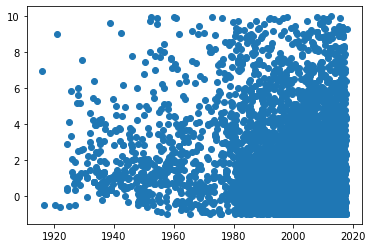

In [104]:
dataset = allData.merge(df, on='id')

subDataSet = dataset[(~dataset['budget'].isna()) & (~dataset['revenue'].isna())]


subDataSet = subDataSet.assign(profit_margin = subDataSet.apply(lambda row: (row['revenue']-row['budget'])/row['budget'], axis=1).values)

reasonableMargin = subDataSet[subDataSet['profit_margin']<10]

print(reasonableMargin['profit_margin'].describe())
print("DataSet with profit Margin count: {0}".format(len(reasonableMargin)))
plt.scatter(reasonableMargin['release_date'], reasonableMargin['profit_margin'])
plt.show()

### Write out Data Wrangled sets

In [107]:
marginFile = "resonableMargins.csv"
reasonableMargin.to_csv(marginFile, sep=',', index=False)

allDataFile = "allData.csv"
reasonableMargin.to_csv(allDataFile, sep=',', index=False)